# Shapley effects

In [1]:
import numpy as np
import pandas as pd
import openturns as ot

import matplotlib.pyplot as plt
from shapley.plots import set_style_paper, plot_sensitivity_results
set_style_paper()

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/D58174/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Custom Framework

In [2]:
from shapley.model import ProbabilisticModel

def test_func(X):
    X = np.asarray(X)
    dim = X.shape[1]
    coef = np.arange(1, dim+1)
    return X.dot(coef)

dim = 3
margins = [ot.Uniform()]*dim
copula = ot.NormalCopula(dim)
input_distribution = ot.ComposedDistribution(margins, copula)
model = ProbabilisticModel(model_func=test_func, input_distribution=input_distribution)

### Monte-Carlo estimation using true model

In [3]:
%%time
from shapley import ShapleyIndices
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

n_perms = None
n_var = 1000
n_outer = 100
n_inner = 3

budget_perms = np.math.factorial(dim) if n_perms is None else n_perms
max_budget = n_var + n_outer * n_inner * budget_perms * (dim - 1)
print('Max budget:', max_budget)

shapley = ShapleyIndices(model.input_distribution)
shapley.build_sample(model=model, n_perms=n_perms, n_var=n_var, n_outer=n_outer, n_inner=n_inner)

Max budget: 4600
CPU times: user 2.36 s, sys: 1.24 s, total: 3.6 s
Wall time: 909 ms


In [4]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

n_boot = 500
shapley_results = shapley.compute_indices(n_boot=n_boot)

CPU times: user 264 ms, sys: 208 ms, total: 472 ms
Wall time: 131 ms


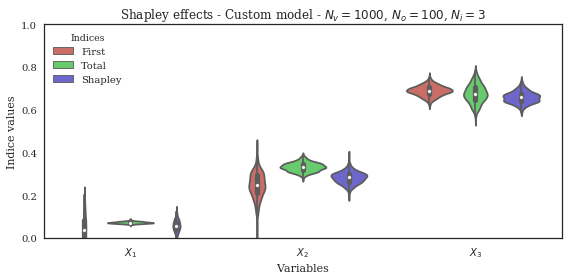

In [5]:
from shapley.plots import plot_sensitivity_results
ylim = [0., 1.]

fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_results, indice='all', ax=ax)
ax.set_title("Shapley effects - {} model - $N_v={}$, $N_o={}$, $N_i={}$".format(model.name, n_var, n_outer, n_inner))
ax.set_ylim(ylim)
fig.tight_layout()

### Monte-Carlo estimation using a Kriging model

In [6]:
from shapley.kriging import KrigingModel

model_budget = 10
sampling = 'lhs'
library = 'gpflow'
kernel = 'matern'
basis = 'linear'

model_gp = KrigingModel(model=model, input_distribution=model.input_distribution)
model_gp.generate_sample(n_sample=model_budget, sampling=sampling, sampling_type='uniform')
model_gp.build(library=library, kernel=kernel, basis_type=basis)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -44.747964
  Number of iterations: 67
  Number of functions evaluations: 93


In [7]:
# The score of the meta_model
q2_score_cv_gp = model_gp.compute_score_q2_cv(n_sample=10000, sampling='monte-carlo')
print('Q2-score by cross-validation:', q2_score_cv_gp)

Q2-score by cross-validation: 0.9999999999999867


In [8]:
%%time
n_realization = 200
shapley.build_sample(model=model_gp, n_perms=n_perms, n_var=n_var, n_outer=n_outer, n_inner=n_inner, n_realization=n_realization)

CPU times: user 10.1 s, sys: 1.55 s, total: 11.6 s
Wall time: 4.68 s


In [9]:
%%time
# Indice estimation
shapley_gp_results = shapley.compute_indices(n_boot=n_boot)

CPU times: user 6.34 s, sys: 0 ns, total: 6.34 s
Wall time: 6.34 s


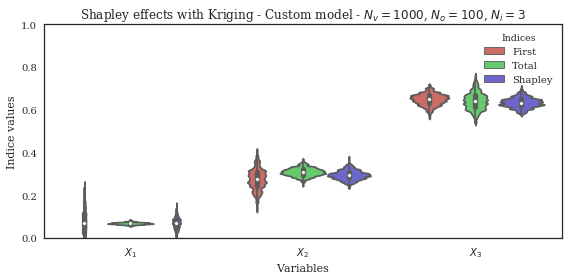

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_gp_results, indice='all', ax=ax)
ax.set_title("Shapley effects with Kriging - {} model - $N_v={}$, $N_o={}$, $N_i={}$".format(model_gp.name, n_var, n_outer, n_inner))
ax.set_ylim(ylim)
fig.tight_layout()

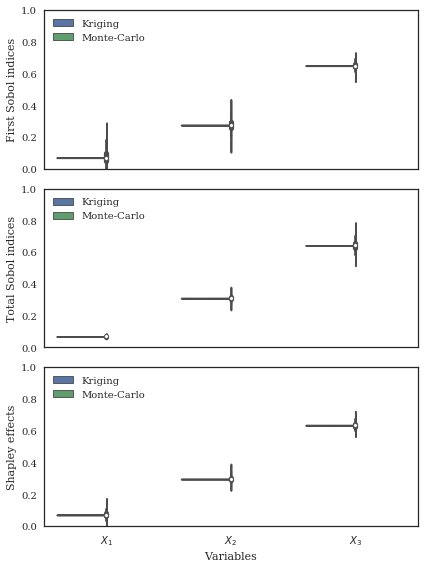

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(6, 8), sharex=True, sharey=True)

ax = axes[0]
plot_sensitivity_results(shapley_gp_results, indice='first', ax=ax)
ax.set_ylim(ylim)
ax.set_xlabel('')
ax.set_ylabel('First Sobol indices')
ax.legend(loc=2)

ax = axes[1]
plot_sensitivity_results(shapley_gp_results, indice='total', ax=ax)
ax.set_ylim(ylim)
ax.legend(loc=2)
ax.set_xlabel('')
ax.set_ylabel('Total Sobol indices')

ax = axes[2]
plot_sensitivity_results(shapley_gp_results, indice='shapley', ax=ax)
ax.set_ylim(ylim)
ax.legend(loc=2)
ax.set_ylabel('Shapley effects')

fig.tight_layout()

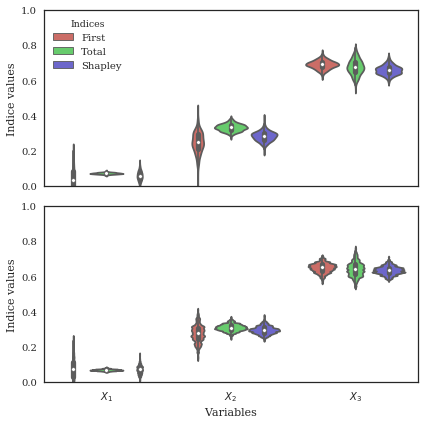

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True, sharey=True)

ax = axes[0]
plot_sensitivity_results(shapley_results, indice='all', ax=ax)
ax.set_xlabel('')
ax.set_ylim(ylim)

ax = axes[1]
plot_sensitivity_results(shapley_gp_results, indice='all', ax=ax)
ax.set_ylim(ylim)
ax.legend([])
fig.tight_layout()

### Monte-Carlo estimation using a Random Forest model

In [13]:
from shapley.forest import RandomForestModel
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
model_budget = 200

model_rf = RandomForestModel(model=model, input_distribution=model.input_distribution)
model_rf.generate_sample(n_sample=model_budget, sampling=sampling, sampling_type='uniform')
model_rf.build(n_realization, method='random-forest')

In [14]:
# The score of the meta_model
q2_score_cv_rf = model_rf.compute_score_q2_cv(n_sample=10000, sampling='monte-carlo')
print('Q2-score by cross-validation:', q2_score_cv_rf)

Q2-score by cross-validation: 0.9657563101352739


In [15]:
%%time
shapley.build_sample(model=model_rf, n_perms=n_perms, n_var=n_var, n_outer=n_outer, n_inner=n_inner, n_realization=n_realization)

CPU times: user 2.76 s, sys: 960 ms, total: 3.72 s
Wall time: 1.16 s


In [16]:
%%time
shapley_rf_results = shapley.compute_indices(n_boot=n_boot)

CPU times: user 3.1 s, sys: 0 ns, total: 3.1 s
Wall time: 3.1 s


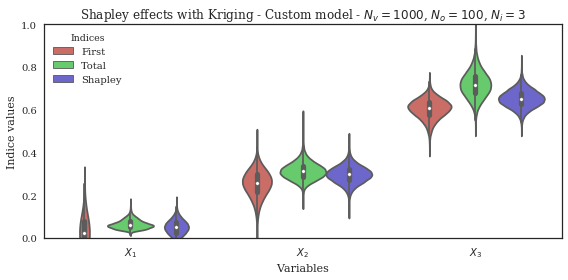

In [17]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_rf_results, indice='all', ax=ax)
ax.set_title("Shapley effects with Kriging - {} model - $N_v={}$, $N_o={}$, $N_i={}$".format(model_gp.name, n_var, n_outer, n_inner))
ax.set_ylim(ylim)
fig.tight_layout()

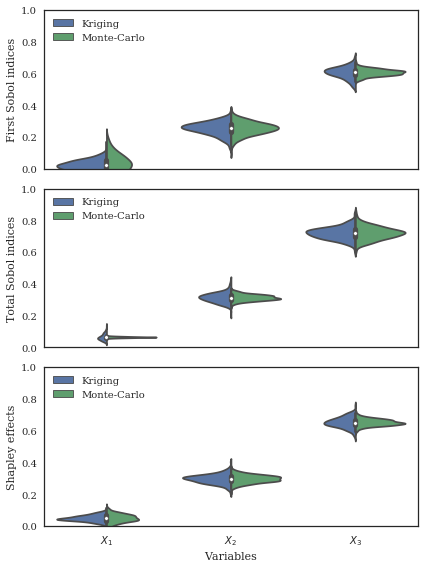

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(6, 8), sharex=True, sharey=True)

ax = axes[0]
plot_sensitivity_results(shapley_rf_results, indice='first', ax=ax)
ax.set_ylim(ylim)
ax.set_xlabel('')
ax.set_ylabel('First Sobol indices')
ax.legend(loc=2)

ax = axes[1]
plot_sensitivity_results(shapley_rf_results, indice='total', ax=ax)
ax.set_ylim(ylim)
ax.legend(loc=2)
ax.set_xlabel('')
ax.set_ylabel('Total Sobol indices')

ax = axes[2]
plot_sensitivity_results(shapley_rf_results, indice='shapley', ax=ax)
ax.set_ylim(ylim)
ax.legend(loc=2)
ax.set_ylabel('Shapley effects')

fig.tight_layout()